In [1]:
# load libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import h5py
from datetime import datetime as dt
import multiprocessing
from joblib import Parallel, delayed
from functools import partial
import scipy.io as sio
from os.path import dirname, join as pjoin

from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator
#import pygmt
#import RAiDER

import multiprocessing
from joblib import Parallel, delayed
from functools import partial
import scipy, matplotlib
from scipy.optimize import curve_fit
from scipy.optimize import differential_evolution
import warnings

from scipy.interpolate import griddata

In [2]:
# define functions
def datenum(d):
    '''
    Serial date number
    used for SBI_Year
    '''
    return 366 + d.toordinal() + (d - dt.fromordinal(d.toordinal())).total_seconds()/(24*60*60)

def SBI_Year(imd):
    '''
    A simple script that takes in numbers on the format '19990930'
    and changes to a number format 1999.7590
    imd - numpy (n,1) Vector with dates in strings
    out - numpy (n,1) Vector with dates in int
    created by Rishabh Dutta
    '''
    dstr = imd
    nd = imd.shape[0]
    out = np.zeros((nd,1))
    for k in range(nd):
        # get first day of year, minus 1/2 a day:
        d1 = dt.strptime(dstr[k][0][0:4]+'0101', '%Y%m%d')
        dn1 = datenum(d1) - 0.5 
        # get last day of year, plus 0.5
        d2 = dt.strptime(dstr[k][0][0:4]+'1231', '%Y%m%d')
        dne = datenum(d2) + 0.5
        # get number of days in that year:
        ndays = dne - dn1 

        # get day of year:
        d3 = dt.strptime(dstr[k][0], '%Y%m%d')
        doy = datenum(d3) - dn1 
        # get fractional year:
        fracyr = doy/ndays
        out[k] = int(dstr[k][0][0:4])+ fracyr 
    return out

from matplotlib import path

def inpolygon(xq, yq, xv, yv):
    shape = xq.shape
    xq = xq.reshape(-1)
    yq = yq.reshape(-1)
    xv = xv.reshape(-1)
    yv = yv.reshape(-1)
    q = [(xq[i], yq[i]) for i in range(xq.shape[0])]
    p = path.Path([(xv[i], yv[i]) for i in range(xv.shape[0])])
    return p.contains_points(q).reshape(shape)

##### run this to load the matlab files

In [3]:
matDT115mle_fname = '/mnt/stor/geob/jlmd9g/Rishabh/SAF/Bay/Sentinel/SAFprocessing/compare_DT115/DT115mle.mat'
matstruct_contents = sio.loadmat(matDT115mle_fname)
DT115mle_timeseries = matstruct_contents['DT115mle_timeseries']
DT115mle_dates = matstruct_contents['DT115mle_dates']
DT115mle_datesforprint = matstruct_contents['DT115mle_datesforprint']
DT115mle_lat1D = matstruct_contents['DT115mle_lat1D']
DT115mle_lon1D = matstruct_contents['DT115mle_lon1D']
DT115mle_lat2D = matstruct_contents['DT115mle_lat2D']
DT115mle_lon2D = matstruct_contents['DT115mle_lon2D']
DT115mle_height = matstruct_contents['DT115mle_height']
DT115mle_azimangle = matstruct_contents['DT115mle_azimangle']
DT115mle_incangle = matstruct_contents['DT115mle_incangle']
DT115mle_velocity = matstruct_contents['DT115mle_velocity']
DT115mle_incali = matstruct_contents['DT115mle_incali']


matDT115evd_fname = '/mnt/stor/geob/jlmd9g/Rishabh/SAF/Bay/Sentinel/SAFprocessing/compare_DT115/DT115evd.mat'
matstruct_contents = sio.loadmat(matDT115evd_fname)
DT115evd_timeseries = matstruct_contents['DT115evd_timeseries']
DT115evd_dates = matstruct_contents['DT115evd_dates']
DT115evd_datesforprint = matstruct_contents['DT115evd_datesforprint']
DT115evd_lat1D = matstruct_contents['DT115evd_lat1D']
DT115evd_lon1D = matstruct_contents['DT115evd_lon1D']
DT115evd_lat2D = matstruct_contents['DT115evd_lat2D']
DT115evd_lon2D = matstruct_contents['DT115evd_lon2D']
DT115evd_height = matstruct_contents['DT115evd_height']
DT115evd_azimangle = matstruct_contents['DT115evd_azimangle']
DT115evd_incangle = matstruct_contents['DT115evd_incangle']
DT115evd_velocity = matstruct_contents['DT115evd_velocity']
DT115evd_incali = matstruct_contents['DT115evd_incali']


matDT115stbas_fname = '/mnt/stor/geob/jlmd9g/Rishabh/SAF/Bay/Sentinel/SAFprocessing/compare_DT115/DT115stbas.mat'
matstruct_contents = sio.loadmat(matDT115stbas_fname)
DT115stbas_timeseries = matstruct_contents['DT115stbas_timeseries']
DT115stbas_dates = matstruct_contents['DT115stbas_dates']
DT115stbas_datesforprint = matstruct_contents['DT115stbas_datesforprint']
DT115stbas_lat1D = matstruct_contents['DT115stbas_lat1D']
DT115stbas_lon1D = matstruct_contents['DT115stbas_lon1D']
DT115stbas_lat2D = matstruct_contents['DT115stbas_lat2D']
DT115stbas_lon2D = matstruct_contents['DT115stbas_lon2D']
DT115stbas_height = matstruct_contents['DT115stbas_height']
DT115stbas_azimangle = matstruct_contents['DT115stbas_azimangle']
DT115stbas_incangle = matstruct_contents['DT115stbas_incangle']
DT115stbas_velocity = matstruct_contents['DT115stbas_velocity']
DT115stbas_incali = matstruct_contents['DT115stbas_incali']

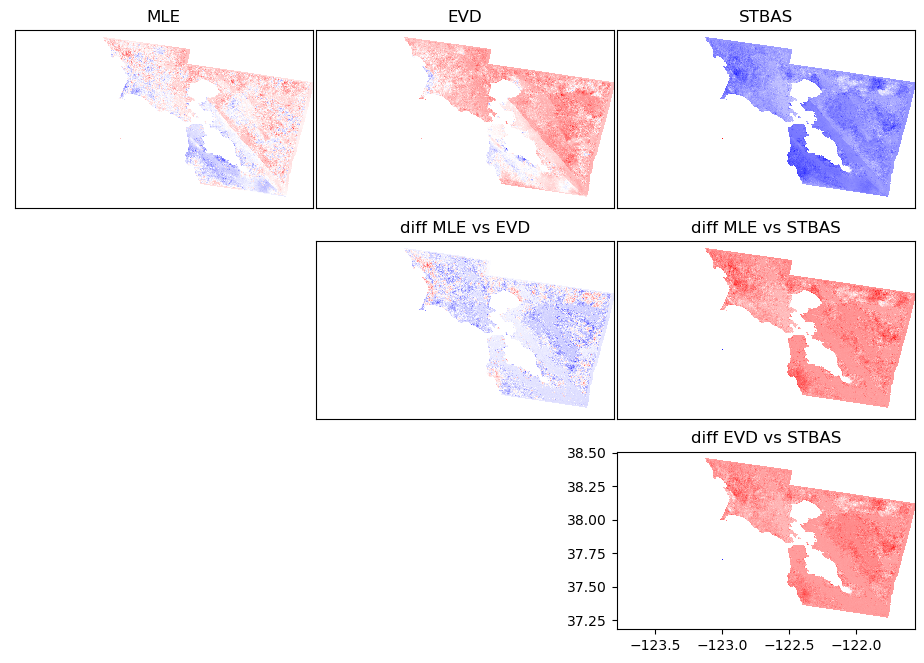

In [4]:
# compare all the descending track velocities

# first get the reference fixed 
lat_ref = 37.78
lon_ref = -122.418

diff_lat = np.abs(DT115mle_lat1D-lat_ref)
diff_lon = np.abs(DT115mle_lon1D-lon_ref)

ind_lat = np.where(diff_lat == np.min(diff_lat))
ind_lon = np.where(diff_lon == np.min(diff_lon))

lat_array = np.int64(np.linspace(ind_lat[1][0]-15,ind_lat[1][0]+15,31))
lon_array = np.int64(np.linspace(ind_lon[1][0]-15,ind_lon[1][0]+15,31))

DT115mle_velocity = DT115mle_velocity #- np.nanmean(DT115mle_velocity[lat_array, lon_array])
DT115evd_velocity = DT115evd_velocity #- np.nanmean(DT115evd_velocity[lat_array, lon_array])
DT115stbas_velocity = DT115stbas_velocity #- np.nanmean(DT115evd_velocity[lat_array, lon_array])

ncols = 3
nrows = 3

# create the plots
fig = plt.figure()
axes = [ fig.add_subplot(nrows, ncols, r * ncols + c+1) for r in range(0, nrows) for c in range(0, ncols) ]

k = 0
# add some data
for ax in axes:
    ival = np.ceil((k+1)/3)-1
    if ((k+1)%3)-1 == -1:
        jval = 2
    else:
        jval = ((k+1)%3)-1
    if k == 0: 
        ax.imshow(DT115mle_velocity, cmap='bwr', 
                  extent=[DT115stbas_lon1D.min(), DT115stbas_lon1D.max(), DT115stbas_lat1D.max(), DT115stbas_lat1D.min()],
                  interpolation='nearest', origin='lower')
        ax.invert_yaxis()
        ax.title.set_text('MLE')
    elif k == 1: 
        ax.imshow(DT115evd_velocity, cmap='bwr', 
                  extent=[DT115stbas_lon1D.min(), DT115stbas_lon1D.max(), DT115stbas_lat1D.max(), DT115stbas_lat1D.min()],
                  interpolation='nearest', origin='lower')
        ax.invert_yaxis()
        ax.title.set_text('EVD')
    elif k == 2:
        ax.imshow(DT115stbas_velocity, cmap='bwr', 
                  extent=[DT115stbas_lon1D.min(), DT115stbas_lon1D.max(), DT115stbas_lat1D.max(), DT115stbas_lat1D.min()],
                  interpolation='nearest', origin='lower')
        ax.invert_yaxis()
        ax.title.set_text('STBAS')
    elif k == 4:
        diffmle_evd = DT115mle_velocity - DT115evd_velocity
        ax.imshow(diffmle_evd, cmap='bwr', 
                  extent=[DT115stbas_lon1D.min(), DT115stbas_lon1D.max(), DT115stbas_lat1D.max(), DT115stbas_lat1D.min()],
                  interpolation='nearest', origin='lower')
        ax.invert_yaxis()
        ax.title.set_text('diff MLE vs EVD')
    elif k == 5:
        diffmle_stbas = DT115mle_velocity - DT115stbas_velocity
        ax.imshow(diffmle_stbas, cmap='bwr', 
                  extent=[DT115stbas_lon1D.min(), DT115stbas_lon1D.max(), DT115stbas_lat1D.max(), DT115stbas_lat1D.min()],
                  interpolation='nearest', origin='lower')
        ax.invert_yaxis()
        ax.title.set_text('diff MLE vs STBAS')
    elif k == 8:
        diffevd_stbas = DT115evd_velocity - DT115stbas_velocity
        ax.imshow(diffevd_stbas, cmap='bwr', 
                  extent=[DT115stbas_lon1D.min(), DT115stbas_lon1D.max(), DT115stbas_lat1D.max(), DT115stbas_lat1D.min()],
                  interpolation='nearest', origin='lower')
        ax.invert_yaxis()
        ax.title.set_text('diff EVD vs STBAS')
    else:
        ax.axis('off')
    
    k = k+1
    
# remove the x and y ticks
k = 0
for ax in axes:
    if k == 8:
        continue
    else:
        ax.set_xticks([])
        ax.set_yticks([])
    k = k+1
    
fig.set_size_inches(9, 6.3)
plt.subplots_adjust(left=0,
                    bottom=0, 
                    right=1, 
                    top=1, 
                    wspace=0.01, 
                    hspace=0.01)

#### Tie each velocity with GPS velocities

    latitude   longitude     height  velocity_north  velocity_east  \
0  34.116409  242.906804  762.11978         0.01648       -0.01573   
1  34.116409  242.906804  762.10883         0.01648       -0.01573   
2  34.116409  242.906805  762.09364         0.01648       -0.01573   
3  34.116409  242.906805  762.09073         0.01648       -0.01573   
4  34.116409  242.906805  762.07699         0.01648       -0.01573   

   velocity_up  std_north  std_east   std_up  
0      0.00261     0.0002   0.00037  0.00053  
1      0.00261     0.0002   0.00037  0.00053  
2      0.00261     0.0002   0.00037  0.00053  
3      0.00261     0.0002   0.00037  0.00053  
4      0.00261     0.0002   0.00037  0.00053  


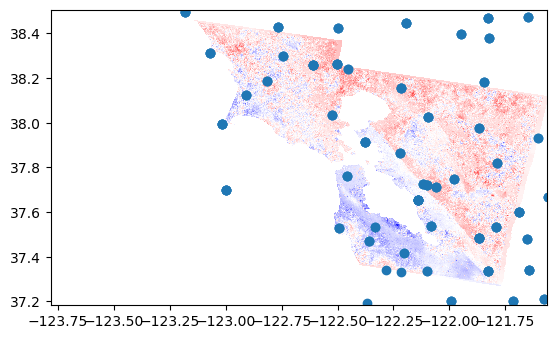

In [5]:
# load GPS data 

import pandas as pd
import verde as vd

# The data are in a pandas.DataFrame
data = vd.datasets.fetch_california_gps()
print(data.head())
arr = data.to_numpy()

fig = plt.figure()
plt.imshow(DT115mle_velocity, cmap='bwr', 
            extent=[DT115stbas_lon1D.min(), DT115stbas_lon1D.max(), DT115stbas_lat1D.max(), DT115stbas_lat1D.min()],
            interpolation='nearest', origin='lower')
xmin = -123.783
xmax = -121.564
ymin = 38.506
ymax = 37.183

plt.plot(arr[:,1]-360,arr[:,0],'o')
plt.xlim(xmin,xmax)
plt.ylim(ymin,ymax)
plt.gca().invert_yaxis()

plt.show()
plt.close('all')

Unique elements:  (32,)
Indices:  [  0   3   8  14  17  20  22  27  31  34  37  40  46  51  53  55  59  63
  66  69  74  78  81  84  87  89  93  97 102 104 107 110]


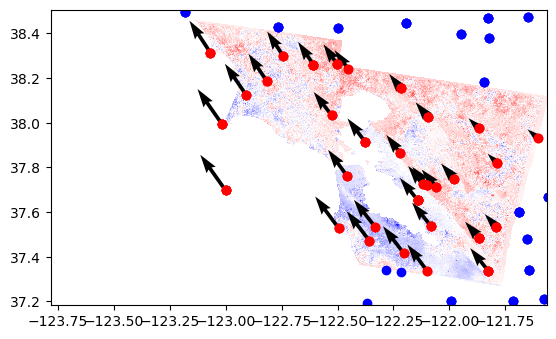

[ 0 16 18 31]
[-122.11931222 -122.09978059 -122.05832972 -122.14063041]  and  [37.72411785 37.72205565 37.71386747 37.6526535 ]


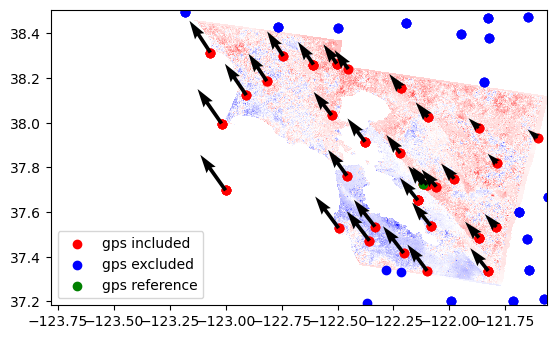

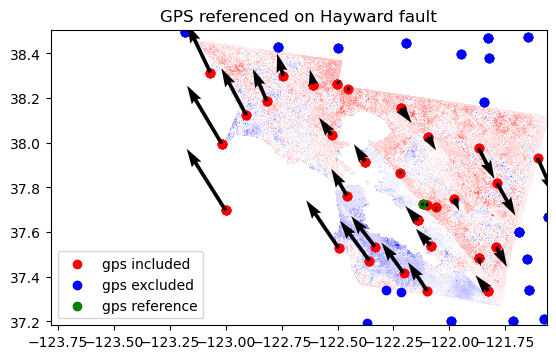

In [6]:
# find GPS location within insar coverage

arr.shape[0]
inInsar = np.empty([arr.shape[0]])

for i in range(arr.shape[0]):
    gpslon = arr[i,1] - 360
    gpslat = arr[i,0]
    
    # find the closest los fringe 
    difflon = np.abs(DT115mle_lon1D - gpslon)
    indlon = np.where(difflon == np.min(difflon))
    
    difflat = np.abs(DT115mle_lat1D - gpslat)
    indlat = np.where(difflat == np.min(difflat))
    
    insarlat = DT115mle_lat2D[indlat[1][0],indlon[1][0]]
    insarlon = DT115mle_lon2D[indlat[1][0],indlon[1][0]]
    
    distgps = np.sqrt((insarlon - gpslon)**2+(insarlat - gpslat)**2)
    
    if np.isnan(distgps) == True:
        inInsar[i] = False
    else:
        if distgps > .01:
            inInsar[i] = False
        else:
            inInsar[i] = True
    
 

fig = plt.figure()
plt.imshow(DT115mle_velocity, cmap='bwr', 
            extent=[DT115stbas_lon1D.min(), DT115stbas_lon1D.max(), DT115stbas_lat1D.max(), DT115stbas_lat1D.min()],
            interpolation='nearest', origin='lower')
xmin = -123.783
xmax = -121.564
ymin = 38.506
ymax = 37.183

ingpslon = arr[np.where(inInsar == True),1] - 360 
outgpslon = arr[np.where(inInsar == False),1] - 360
ingpslat = arr[np.where(inInsar == True),0]
outgpslat = arr[np.where(inInsar == False),0]

inGPS = np.where(inInsar == True)

plt.plot(ingpslon,ingpslat,'ro')
plt.plot(outgpslon,outgpslat,'bo')

gps_included1 = arr[inGPS[0],:] 

input_array = gps_included1[:,1]-360
output_array = np.array([input_array[0]])
output_index = np.array([0])

for i in range(1, len(input_array)):
    if not np.isclose(input_array[i], output_array[-1], rtol=.00001, atol=0.0):
        output_array = np.append(output_array, input_array[i])
        output_index = np.append(output_index, i)

print("Unique elements: ", output_array.shape)
print("Indices: ", output_index)

gps_included2 = gps_included1[output_index,:]

# plot the gps included 
plt.quiver(gps_included2[:,1]-360,gps_included2[:,0],gps_included2[:,4],gps_included2[:,3])

plt.xlim(xmin,xmax)
plt.ylim(ymin,ymax)
plt.gca().invert_yaxis()

plt.show()
plt.close('all')

# take the reference of the gps data on the Hayward fault
# lon between -122.25 and -122 , lat between 37.6 and 37.8 

longps = gps_included2[:,1]-360
latgps = gps_included2[:,0]
indlon = np.where((longps > -122.25) & (longps < -122))
indlon = np.array(indlon).flatten()

indlat = np.where((latgps > 37.6) & (latgps < 37.8))
indlat = np.array(indlat).flatten()

commonid = np.intersect1d(indlat, indlon)
print(commonid)
print(longps[commonid], ' and ',latgps[commonid])

# manually selected 

lonrefgps = gps_included2[0,1] - 360
latrefgps = gps_included2[0,0]

fig = plt.figure()
plt.imshow(DT115mle_velocity, cmap='bwr', 
            extent=[DT115stbas_lon1D.min(), DT115stbas_lon1D.max(), DT115stbas_lat1D.max(), DT115stbas_lat1D.min()],
            interpolation='nearest', origin='lower')
plt.scatter(ingpslon,ingpslat, color='red', label='gps included')
plt.scatter(outgpslon,outgpslat,color='blue', label='gps excluded')
plt.scatter(lonrefgps, latrefgps, color='green', label='gps reference')
plt.quiver(gps_included2[:,1]-360,gps_included2[:,0],gps_included2[:,4],gps_included2[:,3])

plt.xlim(xmin,xmax)
plt.ylim(ymin,ymax)
plt.gca().invert_yaxis()

plt.legend(loc='lower left')

plt.show()
plt.close('all')

eastgps_ref = gps_included2[:,4] - gps_included2[0,4]
northgps_ref = gps_included2[:,3] - gps_included2[0,3]
upgps_ref = gps_included2[:,5] - gps_included2[0,5]


fig = plt.figure()
plt.imshow(DT115mle_velocity, cmap='bwr', 
            extent=[DT115stbas_lon1D.min(), DT115stbas_lon1D.max(), DT115stbas_lat1D.max(), DT115stbas_lat1D.min()],
            interpolation='nearest', origin='lower')
plt.scatter(ingpslon,ingpslat, color='red', label='gps included')
plt.scatter(outgpslon,outgpslat,color='blue', label='gps excluded')
plt.scatter(lonrefgps, latrefgps, color='green', label='gps reference')
plt.quiver(gps_included2[:,1]-360,gps_included2[:,0],eastgps_ref,northgps_ref)

plt.xlim(xmin,xmax)
plt.ylim(ymin,ymax)
plt.gca().invert_yaxis()
plt.title('GPS referenced on Hayward fault')
plt.legend(loc='lower left')

plt.show()
plt.close('all')

#### Fit the InSAR los to GPS los using a plane - MLE

####  Los residuals =  a*x + b*y + c 
####      los_res  =  [x   y   1]* [a  b  c]

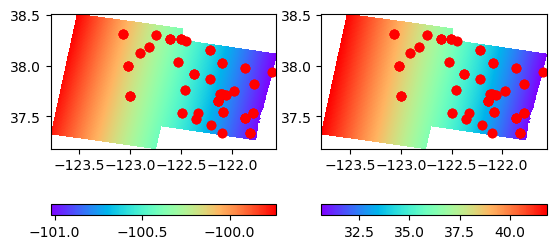

[-1.31939852e-03  3.08119711e-02  1.74313155e-03 -3.42934695e-03
 -5.90439141e-03 -2.83914199e-03 -2.20997375e-03 -1.28167227e-03
 -4.12926544e-04 -1.42930634e-03  7.97999091e-04  2.84670619e-03
  1.37510558e-03  4.60274488e-04 -1.83945533e-03 -2.12351605e-03
  9.69676592e-04 -6.24584136e-05  2.29047122e-03  8.09312100e-04
  3.15217098e-04  5.08452067e-04 -2.83570867e-03  2.05999683e-03
  3.98295932e-04  1.83877861e-03 -2.86655920e-03  5.04821772e-04
 -1.82294718e-03  3.43475724e-03 -1.98369822e-03 -7.03553029e-04]


In [7]:
# generate los residuals vector 

# plot the incidence angle and azimuth angle 
fig = plt.figure()
plt.subplot(1,2,1)
plt.imshow(DT115mle_azimangle, cmap='rainbow', 
            extent=[DT115stbas_lon1D.min(), DT115stbas_lon1D.max(), DT115stbas_lat1D.max(), DT115stbas_lat1D.min()],
            interpolation='nearest', origin='lower')

plt.plot(ingpslon,ingpslat,'ro')

plt.colorbar(orientation = 'horizontal')
plt.xlim(xmin,xmax)
plt.ylim(ymin,ymax)
plt.gca().invert_yaxis()

plt.subplot(1,2,2)
plt.imshow(DT115mle_incangle, cmap='rainbow', 
            extent=[DT115stbas_lon1D.min(), DT115stbas_lon1D.max(), DT115stbas_lat1D.max(), DT115stbas_lat1D.min()],
            interpolation='nearest', origin='lower')

plt.plot(ingpslon,ingpslat,'ro')

plt.xlim(xmin,xmax)
plt.ylim(ymin,ymax)
plt.gca().invert_yaxis()

plt.colorbar(orientation = 'horizontal')

plt.show()
plt.close('all')

losx = np.sin(DT115mle_incangle*np.pi/180)*np.sin(DT115mle_azimangle*np.pi/180)
losy = -np.sin(DT115mle_incangle*np.pi/180)*np.cos(DT115mle_azimangle*np.pi/180)
losz = -np.cos(DT115mle_incangle*np.pi/180)

plt.subplot(1,3,1)
plt.imshow(losx, cmap='rainbow', 
            extent=[DT115stbas_lon1D.min(), DT115stbas_lon1D.max(), DT115stbas_lat1D.max(), DT115stbas_lat1D.min()],
            interpolation='nearest', origin='lower')

plt.plot(ingpslon,ingpslat,'ro')

plt.xlim(xmin,xmax)
plt.ylim(ymin,ymax)
plt.gca().invert_yaxis()
plt.title('LOS X')
plt.colorbar(orientation = 'horizontal')

plt.subplot(1,3,2)
plt.imshow(losy, cmap='rainbow', 
            extent=[DT115stbas_lon1D.min(), DT115stbas_lon1D.max(), DT115stbas_lat1D.max(), DT115stbas_lat1D.min()],
            interpolation='nearest', origin='lower')

plt.plot(ingpslon,ingpslat,'ro')
plt.title('LOS Y')
plt.xlim(xmin,xmax)
plt.ylim(ymin,ymax)
plt.gca().invert_yaxis()

plt.colorbar(orientation = 'horizontal')

plt.subplot(1,3,3)
plt.imshow(losz, cmap='rainbow', 
            extent=[DT115stbas_lon1D.min(), DT115stbas_lon1D.max(), DT115stbas_lat1D.max(), DT115stbas_lat1D.min()],
            interpolation='nearest', origin='lower')

plt.plot(ingpslon,ingpslat,'ro')
plt.title('LOS Z')
plt.xlim(xmin,xmax)
plt.ylim(ymin,ymax)
plt.gca().invert_yaxis()

plt.colorbar(orientation = 'horizontal')


# take a loop over the GPS data to get GPS los and InSAR los 

gpslosall = np.zeros((gps_included2.shape[0]))
mlelosall = np.zeros((gps_included2.shape[0]))
evdlosall = np.zeros((gps_included2.shape[0]))
stbaslosall = np.zeros((gps_included2.shape[0]))
for i in range(gps_included2.shape[0]):
    longps = gps_included2[i,1]-360 
    latgps = gps_included2[i,0] 
    
    difflat = np.abs(DT115mle_lat1D - latgps)
    indlat = np.where(difflat == np.min(difflat))
    
    difflon = np.abs(DT115mle_lon1D - longps)
    indlon = np.where(difflon == np.min(difflon))
    
    #latvalinsar = DT115mle_lat1D[0][indlat[1][0]]
    #lonvalinsar = DT115mle_lon1D[0][indlon[1][0]]
    
    #distgps = np.sqrt((latvalinsar-latgps)**2+(lonvalinsar-longps)**2)
    
    gpslosx = losx[indlat[1][0],indlon[1][0]]
    gpslosy = losy[indlat[1][0],indlon[1][0]]
    gpslosz = losz[indlat[1][0],indlon[1][0]]
    
    gpslos = -gpslosx*eastgps_ref[i] - gpslosy*northgps_ref[i] - gpslosz*upgps_ref[i]
    
    numk = 3
    lat_array = np.int64(np.linspace(indlat[1][0]-numk,indlat[1][0]+numk,2*numk+1))
    lon_array = np.int64(np.linspace(indlon[1][0]-numk,indlon[1][0]+numk,2*numk+1))
    
    losallval1 = np.zeros(((2*numk+1)*(2*numk+1)))
    losallval2 = np.zeros(((2*numk+1)*(2*numk+1)))
    losallval3 = np.zeros(((2*numk+1)*(2*numk+1)))
    hval = 0 
    for j in range(2*numk+1): 
        for k in range(2*numk+1):
            losallval1[hval] = DT115mle_velocity[lat_array[j]][lon_array[k]]
            losallval2[hval] = DT115evd_velocity[lat_array[j]][lon_array[k]]
            losallval3[hval] = DT115stbas_velocity[lat_array[j]][lon_array[k]]
            hval += 1
    #print(losallval)
    
    mlelosall[i] = np.nanmedian(losallval1)
    evdlosall[i] = np.nanmedian(losallval2)
    stbaslosall[i] = np.nanmedian(losallval3)
    gpslosall[i] = gpslos
plt.close()


print(stbaslosall)

In [8]:
# residuals and error model 

mle_res = mlelosall - gpslosall
evd_res = evdlosall - gpslosall
stbas_res = stbaslosall - gpslosall

print('mle_res = ',mle_res)
print('evd_res = ',evd_res)
print('stbas_res = ',stbas_res)

# create [x y 1] matrix 
mleAmat = np.zeros((stbas_res.shape[0],3))

for i in range(stbas_res.shape[0]):
    mleAmat[i,:] = np.array([gps_included2[i,1]-360, gps_included2[i,0], 1])
    
evdAmat = mleAmat
stbasAmat = mleAmat

mle_res = mle_res.reshape((mle_res.shape[0],1))
evd_res = evd_res.reshape((evd_res.shape[0],1))
stbas_res = stbas_res.reshape((stbas_res.shape[0],1))

print(mle_res.shape)

AT_A = np.matmul(mleAmat.T,mleAmat)
AT_Bmle = np.matmul(mleAmat.T,mle_res)
AT_Bevd = np.matmul(mleAmat.T,evd_res)
AT_Bstbas = np.matmul(mleAmat.T,stbas_res)

print(AT_A.shape)
mle_par = np.linalg.solve(AT_A, AT_Bmle)
evd_par = np.linalg.solve(AT_A, AT_Bevd)
stbas_par = np.linalg.solve(AT_A, AT_Bstbas)

print(mle_par,' ', evd_par, ' ', stbas_par)
#mle_res_model = np.matmul(mleAmat, mle_par)
#evd_res_model = np.matmul(mleAmat, evd_par)
#stbas_res_model = np.matmul(mleAmat, stbas_par)


mle_res =  [-0.00110963  0.01066569 -0.00097219  0.00261342  0.00411009  0.0030792
  0.00036705  0.00503246  0.00572648  0.00421836  0.00062819  0.00246813
  0.00222096  0.0020445   0.00142271  0.00078657 -0.0002815   0.00025393
  0.0018505   0.00142735 -0.00347637 -0.00294903 -0.00309252 -0.00309806
 -0.00339008 -0.00148339 -0.00286759  0.00784259  0.00202033  0.00210308
  0.00113468  0.00075614]
evd_res =  [ 0.00259521  0.01213714  0.00038656  0.00560738  0.0051106   0.00527073
  0.00215537  0.00484215  0.00508995  0.00593685  0.00381085  0.00532448
  0.00355547  0.00361656  0.00431654  0.00335738  0.00306107  0.0023407
  0.00404634  0.00413746 -0.00144679  0.00083573 -0.00049238 -0.00156786
 -0.001051    0.00117199  0.00091556  0.01241452  0.00449296  0.00569997
  0.00297278  0.00287041]
stbas_res =  [-1.31939852e-03  4.00961093e-02  1.00588984e-03  2.75707187e-03
  1.27548125e-03  3.83534553e-03  5.58597163e-04  5.04602182e-03
  5.70478668e-03  2.74069001e-03  3.10002315e-03  4.703

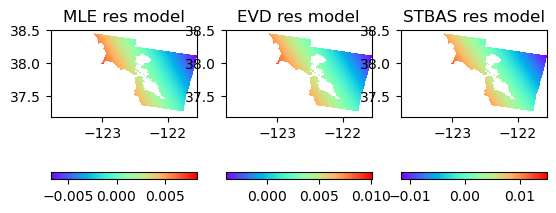

In [9]:
# GPS -referenced velocities

mle_res_model = np.zeros((DT115mle_velocity.shape[0], DT115mle_velocity.shape[1]))

for i in range(DT115mle_velocity.shape[0]):
    for j in range(DT115mle_velocity.shape[1]):
        if np.isnan(DT115mle_velocity[i,j]) == True:
            mle_res_model[i,j] = np.nan
        else: 
            matloc = np.array([[DT115mle_lon2D[i,j], DT115mle_lat2D[i,j], 1]])
            mle_res_model[i,j] = np.matmul(matloc,mle_par)

fig = plt.figure()
plt.subplot(1,3,1)
plt.imshow(mle_res_model, cmap='rainbow', 
            extent=[DT115stbas_lon1D.min(), DT115stbas_lon1D.max(), DT115stbas_lat1D.max(), DT115stbas_lat1D.min()],
            interpolation='nearest', origin='lower')

#plt.plot(ingpslon,ingpslat,'ro')

plt.xlim(xmin,xmax)
plt.ylim(ymin,ymax)
plt.gca().invert_yaxis()
plt.title('MLE res model')
plt.colorbar(orientation = 'horizontal')


evd_res_model = np.zeros((DT115evd_velocity.shape[0], DT115evd_velocity.shape[1]))

for i in range(DT115evd_velocity.shape[0]):
    for j in range(DT115evd_velocity.shape[1]):
        if np.isnan(DT115evd_velocity[i,j]) == True:
            evd_res_model[i,j] = np.nan
        else: 
            matloc = np.array([[DT115mle_lon2D[i,j], DT115mle_lat2D[i,j], 1]])
            evd_res_model[i,j] = np.matmul(matloc,evd_par)
            
plt.subplot(1,3,2)
plt.imshow(evd_res_model, cmap='rainbow', 
            extent=[DT115evd_lon1D.min(), DT115evd_lon1D.max(), DT115evd_lat1D.max(), DT115evd_lat1D.min()],
            interpolation='nearest', origin='lower')

#plt.plot(ingpslon,ingpslat,'ro')

plt.xlim(xmin,xmax)
plt.ylim(ymin,ymax)
plt.gca().invert_yaxis()
plt.title('EVD res model')
plt.colorbar(orientation = 'horizontal')


stbas_res_model = np.zeros((DT115stbas_velocity.shape[0], DT115stbas_velocity.shape[1]))

for i in range(DT115stbas_velocity.shape[0]):
    for j in range(DT115stbas_velocity.shape[1]):
        if np.isnan(DT115stbas_velocity[i,j]) == True:
            stbas_res_model[i,j] = np.nan
        else: 
            matloc = np.array([[DT115mle_lon2D[i,j], DT115mle_lat2D[i,j], 1]])
            stbas_res_model[i,j] = np.matmul(matloc,stbas_par)
            
plt.subplot(1,3,3)
plt.imshow(stbas_res_model, cmap='rainbow', 
            extent=[DT115stbas_lon1D.min(), DT115stbas_lon1D.max(), DT115stbas_lat1D.max(), DT115stbas_lat1D.min()],
            interpolation='nearest', origin='lower')

#plt.plot(ingpslon,ingpslat,'ro')

plt.xlim(xmin,xmax)
plt.ylim(ymin,ymax)
plt.gca().invert_yaxis()
plt.title('STBAS res model')
plt.colorbar(orientation = 'horizontal')

plt.show()
plt.close()

In [10]:
# plot the faults 

import csv

def plotfaults():
    '''
    function to call for plotting all the faults for study region 
    '''
    
    with open('clippedqfaults.csv') as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        line_count = 0
        for row in csv_reader:
            faulttype = row[7]
            if line_count == 0:
                line_count += 1
                continue
            elif line_count < 16047:
            #elif line_count < 160:
                line_count += 1
                try:
                    # for linestring
                    faultloc = row[0]
                    floc1 = faultloc.split("(", 1)
                    floc2 = floc1[1].split(")",1)
                    floc3 = floc2[0].split(",")
                    #print(floc3)
                    floc3 = np.array(floc3)
                    xval = np.zeros((floc3.shape[0]))
                    yval = np.zeros((floc3.shape[0]))
                    for i in range(floc3.shape[0]):
                        xyval = floc3[i]
                        vals = xyval.split(" ")
                        xval[i] = np.float32(vals[0])
                        yval[i] = np.float32(vals[1])
                    if faulttype == 'undifferentiated Quaternary':
                        #fig.plot(x=xval, y=yval, pen="0.5p,gray")
                        ax.plot(xval,yval,linewidth=0.05, color='gray')
                    elif faulttype == 'historic': 
                        #fig.plot(x=xval, y=yval, pen="1.5p,red")
                        ax.plot(xval,yval,linewidth=0.2, color='red')
                    elif faulttype == 'latest Quaternary': 
                        #fig.plot(x=xval, y=yval, pen="1.5p,chocolate4")
                        ax.plot(xval,yval,linewidth=0.2, color='brown')
            
                except: 
                    # for multilinestring
                    faultloc = row[0]
                    floc1 = faultloc.split("(")
                    floc1 = np.array(floc1)
                    for i in range(floc1.shape[0]):
                        if i == 0:
                            continue
                        elif i == 1: 
                            continue
                        else:
                            floc2 = floc1[i]
                            floc3 = floc2.split(")",1)
        
                            floc4 = floc3[0].split(",")
                            floc4 = np.array(floc4)
        
                            xval = np.zeros((floc4.shape[0]))
                            yval = np.zeros((floc4.shape[0]))
                            for j in range(floc4.shape[0]):
                                xyval = floc4[j]
                                vals = xyval.split(" ")
                                xval[j] = np.float32(vals[0])
                                yval[j] = np.float32(vals[1])

                            if faulttype == 'undifferentiated Quaternary':
                                #fig.plot(x=xval, y=yval, pen="0.5p,gray")
                                ax.plot(xval,yval,linewidth=0.05, color='gray')
                            elif faulttype == 'historic': 
                                #fig.plot(x=xval, y=yval, pen="1.5p,red")
                                ax.plot(xval,yval,linewidth=0.2, color='red')
                            elif faulttype == 'latest Quaternary': 
                                #fig.plot(x=xval, y=yval, pen="1.5p,chocolate4")
                                ax.plot(xval,yval,linewidth=0.2, color='brown')
                            
            else:
                break
            
    

/home/rd873/anaconda3/envs/isce2/lib/python3.7/site-packages/ipykernel_launcher.py:85: UserWarning: FixedFormatter should only be used together with FixedLocator
/home/rd873/anaconda3/envs/isce2/lib/python3.7/site-packages/ipykernel_launcher.py:112: UserWarning: FixedFormatter should only be used together with FixedLocator
/home/rd873/anaconda3/envs/isce2/lib/python3.7/site-packages/ipykernel_launcher.py:142: UserWarning: FixedFormatter should only be used together with FixedLocator


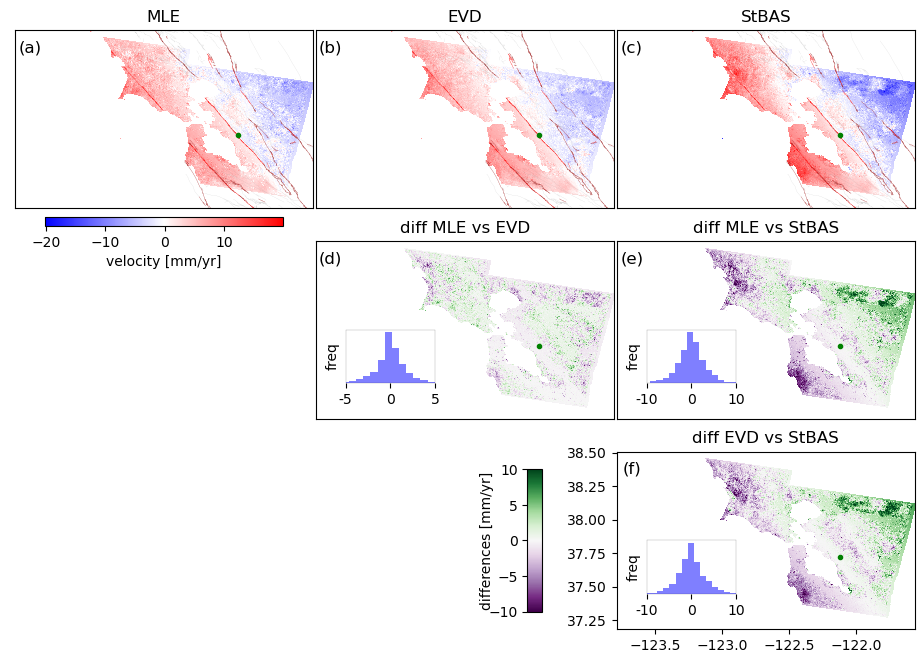

In [12]:
mle_refvel = -(DT115mle_velocity - mle_res_model)
evd_refvel = -(DT115evd_velocity - evd_res_model)
stbas_refvel = -(DT115stbas_velocity - stbas_res_model)

min_val = np.nanmin(np.array([mle_refvel, evd_refvel, stbas_refvel]))*1e3
max_val = np.nanmax(np.array([mle_refvel, evd_refvel, stbas_refvel]))*1e3

ncols = 3
nrows = 3

# create the plots
fig = plt.figure()
axes = [ fig.add_subplot(nrows, ncols, r * ncols + c+1) for r in range(0, nrows) for c in range(0, ncols) ]

k = 0
# add some data
for ax in axes:
    ival = np.ceil((k+1)/3)-1
    if ((k+1)%3)-1 == -1:
        jval = 2
    else:
        jval = ((k+1)%3)-1
    if k == 0: 
        im2 = ax.imshow(mle_refvel*1e3, cmap='bwr', vmin = min_val, vmax = max_val,
                  extent=[DT115stbas_lon1D.min(), DT115stbas_lon1D.max(), DT115stbas_lat1D.max(), DT115stbas_lat1D.min()],
                  interpolation='nearest', origin='lower')
        x_min, x_max = ax.get_xlim()
        y_min, y_max = ax.get_ylim()
        plotfaults()
        ax.plot(lonrefgps, latrefgps, 'g.', label='gps reference')
        ax.set_xlim(x_min, x_max)
        ax.set_ylim(y_min, y_max)
        ax.invert_yaxis()
        ax.title.set_text('MLE')
        ax.text(0.05, 0.9, '(a)', fontsize=12, transform=ax.transAxes, ha='center', va='center')
        cb2 = fig.colorbar(im2, ax=ax, cax=ax.inset_axes([.1, -0.1, 0.8, 0.05]), orientation='horizontal')
        cb2.set_label('velocity [mm/yr]')
    elif k == 1: 
        ax.imshow(evd_refvel*1e3, cmap='bwr',  vmin = min_val, vmax = max_val,
                  extent=[DT115stbas_lon1D.min(), DT115stbas_lon1D.max(), DT115stbas_lat1D.max(), DT115stbas_lat1D.min()],
                  interpolation='nearest', origin='lower')
        x_min, x_max = ax.get_xlim()
        y_min, y_max = ax.get_ylim()
        plotfaults()
        ax.plot(lonrefgps, latrefgps, 'g.', label='gps reference')
        ax.set_xlim(x_min, x_max)
        ax.set_ylim(y_min, y_max)
        ax.invert_yaxis()
        ax.title.set_text('EVD')
        ax.text(0.05, 0.9, '(b)', fontsize=12, transform=ax.transAxes, ha='center', va='center')
    elif k == 2:
        ax.imshow(stbas_refvel*1e3, cmap='bwr',  vmin = min_val, vmax = max_val,
                  extent=[DT115stbas_lon1D.min(), DT115stbas_lon1D.max(), DT115stbas_lat1D.max(), DT115stbas_lat1D.min()],
                  interpolation='nearest', origin='lower')
        x_min, x_max = ax.get_xlim()
        y_min, y_max = ax.get_ylim()
        plotfaults()
        ax.plot(lonrefgps, latrefgps, 'g.', label='gps reference')
        ax.set_xlim(x_min, x_max)
        ax.set_ylim(y_min, y_max)
        ax.invert_yaxis()
        ax.title.set_text('StBAS')
        ax.text(0.05, 0.9, '(c)', fontsize=12, transform=ax.transAxes, ha='center', va='center')
    elif k == 4:
        diffmle_evd = mle_refvel - evd_refvel
        ax.imshow(diffmle_evd*1e3, cmap='PRGn', vmin = -10, vmax = 10,
                  extent=[DT115stbas_lon1D.min(), DT115stbas_lon1D.max(), DT115stbas_lat1D.max(), DT115stbas_lat1D.min()],
                  interpolation='nearest', origin='lower')
        ax.invert_yaxis()
        ax.title.set_text('diff MLE vs EVD')
        ax.text(0.05, 0.9, '(d)', fontsize=12, transform=ax.transAxes, ha='center', va='center')
        ax.plot(lonrefgps, latrefgps, 'g.', label='gps reference')
        
        # Create an inset plot in the second subplot
        alldiff = diffmle_evd.flatten()
        
        axins = ax.inset_axes([0.1, 0.2, 0.3, 0.3])
        axins.hist(alldiff*1e3, bins=30, alpha=0.5, color='blue')

        # Add a label to the inset plot
        axins.set_ylabel('freq')

        axins.set_yticks([])
        axins.set_xlim(-5, 5)
        axins.set_xticklabels(['-5', '0', '5'])
        axins.spines['bottom'].set_linewidth(0.1)
        axins.spines['left'].set_linewidth(0.1)
        axins.spines['right'].set_linewidth(0.1)
        axins.spines['top'].set_linewidth(0.1)

    elif k == 5:
        diffmle_stbas = mle_refvel - stbas_refvel
        ax.imshow(diffmle_stbas*1e3, cmap='PRGn', vmin = -10, vmax = 10,
                  extent=[DT115stbas_lon1D.min(), DT115stbas_lon1D.max(), DT115stbas_lat1D.max(), DT115stbas_lat1D.min()],
                  interpolation='nearest', origin='lower')
        ax.invert_yaxis()
        ax.title.set_text('diff MLE vs StBAS')
        ax.text(0.05, 0.9, '(e)', fontsize=12, transform=ax.transAxes, ha='center', va='center')
        ax.plot(lonrefgps, latrefgps, 'g.', label='gps reference')
        
        # Create an inset plot in the second subplot
        alldiff = diffmle_stbas.flatten()
        
        axins = ax.inset_axes([0.1, 0.2, 0.3, 0.3])
        axins.hist(alldiff*1e3, bins=30, alpha=0.5, color='blue')

        # Add a label to the inset plot
        axins.set_ylabel('freq')

        axins.set_yticks([])
        axins.set_xlim(-10, 10)
        axins.set_xticklabels(['-10', '0', '10'])
        axins.spines['bottom'].set_linewidth(0.1)
        axins.spines['left'].set_linewidth(0.1)
        axins.spines['right'].set_linewidth(0.1)
        axins.spines['top'].set_linewidth(0.1)
        
    elif k == 8:
        diffevd_stbas = evd_refvel - stbas_refvel
        im3 = ax.imshow(diffevd_stbas*1e3, cmap='PRGn', vmin = -10, vmax = 10,
                  extent=[DT115stbas_lon1D.min(), DT115stbas_lon1D.max(), DT115stbas_lat1D.max(), DT115stbas_lat1D.min()],
                  interpolation='nearest', origin='lower')
        ax.invert_yaxis()
        ax.title.set_text('diff EVD vs StBAS')
        ax.text(0.05, 0.9, '(f)', fontsize=12, transform=ax.transAxes, ha='center', va='center')
        ax.plot(lonrefgps, latrefgps, 'g.', label='gps reference')
        cb3 = fig.colorbar(im3, ax=ax, cax=ax.inset_axes([-.3, 0.1, 0.05, 0.8]))
        cb3.ax.yaxis.set_ticks_position('left')
        cb3.set_label('differences [mm/yr]', labelpad=-45)
        
        # Create an inset plot in the second subplot
        alldiff = diffevd_stbas.flatten()
        
        axins = ax.inset_axes([0.1, 0.2, 0.3, 0.3])
        axins.hist(alldiff*1e3, bins=30, alpha=0.5, color='blue')

        # Add a label to the inset plot
        axins.set_ylabel('freq')

        axins.set_yticks([])
        axins.set_xlim(-10, 10)
        axins.set_xticklabels(['-10', '0', '10'])
        axins.spines['bottom'].set_linewidth(0.1)
        axins.spines['left'].set_linewidth(0.1)
        axins.spines['right'].set_linewidth(0.1)
        axins.spines['top'].set_linewidth(0.1)
        
    else:
        ax.axis('off')
    
    k = k+1
    
# remove the x and y ticks
k = 0
for ax in axes:
    if k == 8:
        continue
    else:
        ax.set_xticks([])
        ax.set_yticks([])
    k = k+1
    
fig.set_size_inches(9, 6.3)
plt.subplots_adjust(left=0,
                    bottom=0, 
                    right=1, 
                    top=1, 
                    wspace=0.01, 
                    hspace=0.01)

#plt.savefig("fig7.pdf", format='pdf', dpi=200)
plt.show()
plt.close()